In [1]:
#This jupyter notebook needs sympy: https://docs.sympy.org/latest/index.html
import sympy
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
#Design variables (Kresling was printed with these all in mm)
N = 6 #Number of Kresling edges
L_c = 10 #Contracted length
R = 30 #Polygon radius
phi = np.pi/N #Inner angle on top face
lambda_val = 0.75 #Angle ratio

#Solved  variables
gamma = np.pi/2 - phi 
alpha_c = 2 * gamma * lambda_val #Compressed rotation
alpha_e = 2 * gamma * (1 - lambda_val) #Extended rotation
L_e_num = sympy.sqrt(L_c ** 2 + 2 * R ** 2 *(sympy.cos(alpha_e + 2 * phi) - sympy.cos(alpha_c + 2 * phi))) #Extended length

L_e_array = np.arange(float(L_e_num)-14, float(L_e_num), 0.2)

#The Kresling length L_e is the variable to be solved for
L_e = sympy.symbols('L_e')
alpha_pi = sympy.acos((L_e ** 2 - L_c ** 2)/(2 * R ** 2) + sympy.cos(alpha_c + 2 * phi)) - 2 * phi

#Four points define the upper and lower set of Kresling faces 
P0L = sympy.Matrix([R * sympy.cos(0), R * sympy.sin(0), 0])
P1L = sympy.Matrix([R * sympy.cos(2 * phi), R * sympy.sin(2 * phi), 0])
P0U = sympy.Matrix([R * sympy.cos(-alpha_pi), R * sympy.sin(-alpha_pi), L_e])
P1U = sympy.Matrix([R * sympy.cos(2 * phi - alpha_pi), R * sympy.sin(2 * phi - alpha_pi), L_e])

#Solve for vector normal to lower and upper faces
#Two vectors that define the lower face, from distance between points
lower_vec0 = P0U - P1L
lower_vec1 = P0U - P0L

#Two vectors that define the lower face, from distance between points
upper_vec1 = P0U - P1U
#The second vector is lower_vec0

#Find cross product to find normal vector
normal_lower = lower_vec0.col(0).cross(lower_vec1)
normal_upper = lower_vec0.col(0).cross(upper_vec1)

vec_dot_prod = normal_lower.col(0).dot(normal_upper)
norm_lower = normal_lower.col(0).norm()
norm_upper = normal_upper.col(0).norm()

cos_fold_angle = vec_dot_prod / (norm_lower * norm_upper)

fold_angle = sympy.acos(cos_fold_angle)

fold_angle_rad = []

for lengths in L_e_array:
    fold_angle_rad.append(float(fold_angle.subs(L_e, lengths)))

fold_angle_deg = np.array(fold_angle_rad)*180/3.14

In [3]:
#Find polynomial fit from angle xi in degrees to length in mm
poly_fold_fit = np.polynomial.polynomial.polyfit(fold_angle_deg, np.array(L_e_array), 1)
fold_fit_lin = np.polynomial.polynomial.polyval(fold_angle_deg, poly_fold_fit)

rmse_len = np.sqrt(np.mean((L_e_array - fold_fit_lin)**2))
print("RMSE for kinematic model fit is " + str(round(rmse_len,2)) + " mm")
print("Slope of the fit is " + str(round(poly_fold_fit[1],2)) + " mm/deg and offset is " + str(round(poly_fold_fit[0],2)) + " mm")

RMSE for kinematic model fit is 0.03 mm
Slope of the fit is 0.22 mm/deg and offset is 10.39 mm


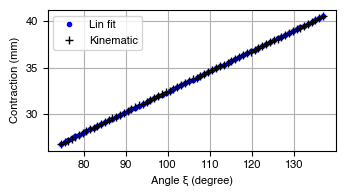

In [5]:
plt.figure(figsize=(3.5,2),facecolor=(1, 1, 1),tight_layout=True)
output_figure_name = 'kinematic_model_fit.png'

colors = ['b', 'k', 'g', 'c']

plt.plot(fold_angle_deg,fold_fit_lin, colors[0]+'.', linewidth=2)
plt.plot(fold_angle_deg, L_e_array, colors[1]+'+')

SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.legend(['Lin fit', 'Kinematic'])
plt.grid('True')

plt.xlabel('Angle ξ (degree)')
plt.ylabel('Contraction (mm)')


plt.rcParams['font.sans-serif'] = ['Helvetica', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana']

plt.savefig(output_figure_name, dpi=300.0, format='png', metadata=None,
        bbox_inches=None, 
        facecolor='auto', edgecolor='auto', transparent=False,
        backend=None)


plt.show()

In [6]:
#Demonstrate fit between alpha angle rotation and measured rotation in optitrack
disp_rot = []
disp = []

with open("optitrack.csv") as readfile:
    reader = csv.reader(readfile, delimiter=',')
    for i in range(6):
        next(reader)
    for line in readfile:
        values = line.split(',')
        disp_rot.append(float(values[3]))
        disp.append(float(values[6]))

index = np.argmax(disp)
disp_zero = np.array(disp) - max(disp) #zero displacement
disp_rot = np.array(disp_rot) 

model_rot = (np.arccos(((disp_zero + 41)** 2 - L_c ** 2) / (2 * R ** 2) + np.cos(alpha_c + 2 * phi)) - 2 * phi) * 180/np.pi
model_rot_min = (np.arccos(((disp_zero[index] + 41)** 2 - L_c ** 2) / (2 * R ** 2) + np.cos(alpha_c + 2 * phi)) - 2 * phi) * 180/np.pi

#calculate RMSE from zeroed rotation values
rmse_deg = np.sqrt(np.mean((-1*(model_rot-model_rot_min)-(disp_rot-disp_rot[index]))**2))
print("Optitrack to kinematic RMSE is: " + str(round(rmse_deg,2)) + " degrees")

Optitrack to kinematic RMSE is: 1.51 degrees


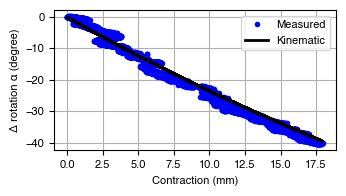

In [7]:
#Plot optitrack measurements and length prediction for open loop control

plt.figure(figsize=(3.5,2),facecolor=(1, 1, 1),tight_layout=True)
output_figure_name = 'alpha_match.png'

plt.plot(-1 * disp_zero, disp_rot - disp_rot[index], colors[0]+'.')
plt.plot(-1 * disp_zero, -1*(model_rot - model_rot_min), colors[1], linewidth=2)


SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.legend(['Measured', 'Kinematic'])

plt.xlabel('Contraction (mm)')
plt.ylabel('Δ rotation α (degree)')
plt.grid('True')

plt.rcParams['font.sans-serif'] = ['Helvetica', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana']

plt.savefig(output_figure_name, dpi=300.0, format='png', metadata=None,
        bbox_inches=None, 
        facecolor='auto', edgecolor='auto', transparent=False,
        backend=None)

plt.show()